# Earth-Mars transfer window design using Porkchop Plots

Copyright (c) 2010-2024, Delft University of Technology
All rigths reserved
This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.

## Summary

This example demonstrates the usage of the tudatpy `porkchop` module to determine an optimal launch window (departure and arrival date) for a **low-thrust** Earth-Mars transfer mission.
By default, the porkchop module uses a Lambert arc to compute the $\Delta V$ required to depart from the departure body (Earth in this case) and be captured by the target body (in this case Mars).
Users can provide a custom function to calculate the $\Delta V$ required for any given transfer. This can be done by supplying a `callable` (a function) to the `porkchop` function via the argument

    function_to_calculate_delta_v

In this example, this option will be used to choose (make a preliminary choice, that is) the optimal departure and arrival date of a low-thrust transfer from the Earth to Mars.

## Import statements

The required import statements are made here, starting with standard imports (`os`, `pickle` from the Python Standard Library), followed by tudatpy imports.

In [1]:
# General imports
import os
import time
import pickle
import numpy as np

# Tudat imports
import tudatpy
from tudatpy import constants
from tudatpy.interface import spice_interface
from tudatpy.astro.time_conversion import DateTime
from tudatpy.trajectory_design import shape_based_thrust
from tudatpy.trajectory_design import transfer_trajectory
from tudatpy.numerical_simulation import environment_setup
from tudatpy.trajectory_design.porkchop import porkchop, plot_porkchop

## Environment setup

The simulation environment is set up here: the standard Spice kernels are loaded, the origin of the global frame is defined, and all necessary bodies are created. 


In [2]:

# Load spice kernels
spice_interface.load_standard_kernels( )

# Define global frame orientation
global_frame_orientation = 'ECLIPJ2000'

# Create bodies
bodies_to_create = ['Sun', 'Venus', 'Earth', 'Moon', 'Mars', 'Jupiter', 'Saturn']
global_frame_origin = 'Sun'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create environment model
bodies = environment_setup.create_system_of_bodies(body_settings)

# Create vehicle object and add it to the existing system of bodies
vehicle_mass = 4.0E3
bodies.create_empty_body('Vehicle')
bodies.get_body('Vehicle').mass = vehicle_mass

## Shape-based low-thrust trajectory optimization

Define the necessary parameters of the low-thrust trajectory:

- Number of revolutions around the Sun
- Free parameters for radial shaping functions
- Free parameters for normal shaping functions
- Free parameters for axial shaping functions


In [3]:
number_of_revolutions = 2

radial_velocity_shaping_free_coefficients = [
    2471.19649906354,
    4207.587982407276
]
normal_velocity_shaping_free_coefficients = [
    -5594.040587888714,
    8748.139268525232,
]
axial_velocity_shaping_free_coefficients = [
    -3449.838496679572,
    0.0
]

### Velocity shaping functions

Define a factory function to obtain the radial velocity shaping functions


In [4]:

def get_radial_velocity_shaping_functions(trajectory_parameters: list,
                                          frequency: float,
                                          scale_factor: float,
                                          time_of_flight: float,
                                          number_of_revolutions: int) -> tuple:
    """
    Retrieves the radial velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun (currently unused).

    Returns
    -------
    tuple
        A tuple composed by two lists: the radial velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    radial_velocity_shaping_functions = shape_based_thrust.recommended_radial_hodograph_functions(time_of_flight)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    radial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    radial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    # Set free parameters
    free_coefficients = trajectory_parameters[3:5]
    return (radial_velocity_shaping_functions,
            free_coefficients)

Define a factory function to obtain the normal velocity shaping functions

In [5]:

def get_normal_velocity_shaping_functions(trajectory_parameters: list,
                                          frequency: float,
                                          scale_factor: float,
                                          time_of_flight: float,
                                          number_of_revolutions: int) -> tuple:
    """
    Retrieves the normal velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun (currently unused).

    Returns
    -------
    tuple
        A tuple composed by two lists: the normal velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    normal_velocity_shaping_functions = shape_based_thrust.recommended_normal_hodograph_functions(time_of_flight)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    normal_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    normal_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    # Set free parameters
    free_coefficients = trajectory_parameters[5:7]
    return (normal_velocity_shaping_functions,
            free_coefficients)

Define a factory function to obtain the axial velocity shaping functions

In [6]:
def get_axial_velocity_shaping_functions(trajectory_parameters: list,
                                         frequency: float,
                                         scale_factor: float,
                                         time_of_flight: float,
                                         number_of_revolutions: int) -> tuple:
    """
    Retrieves the axial velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list[ float ]
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun.

    Returns
    -------
    tuple
        A tuple composed by two lists: the axial velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    axial_velocity_shaping_functions = shape_based_thrust.recommended_axial_hodograph_functions(
        time_of_flight,
        number_of_revolutions)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    exponent = 4.0
    axial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=exponent,
        frequency=(number_of_revolutions + 0.5) * frequency,
        scale_factor=scale_factor ** exponent))
    axial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=exponent,
        frequency=(number_of_revolutions + 0.5) * frequency,
        scale_factor=scale_factor ** exponent))
    # Set free parameters
    free_coefficients = trajectory_parameters[7:9]
    return (axial_velocity_shaping_functions,
            free_coefficients)

### Low-thrust Trajectory Optimization solution

Define a function to obtain the LTTO solution

In [7]:

def create_hodographic_trajectory(
        trajectory_parameters: list,
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        departure_body: str,
        target_body: str,
        central_body: str) \
        -> tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory:
    """
    It creates and returns the hodographic shaping object, based on the trajectory parameters.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to be optimized.
    bodies : tudatpy.numerical_simulation.environment.SystemOfBodies
        System of bodies present in the simulation.

    Returns
    -------
    hodographic_shaping_object : tudatpy.trajectory_design.shape_based_thrust.HodographicShaping
        Hodographic shaping object.
    """

    # Time settings
    initial_time = trajectory_parameters[0] * constants.JULIAN_DAY
    time_of_flight = trajectory_parameters[1] * constants.JULIAN_DAY
    final_time = initial_time + time_of_flight
    
    # Number of revolutions
    number_of_revolutions = int(trajectory_parameters[2])
    
    # Compute relevant frequency and scale factor for shaping functions
    frequency = 2.0 * np.pi / time_of_flight
    scale_factor = 1.0 / time_of_flight
    
    # Retrieve shaping functions and free parameters
    radial_velocity_shaping_functions, radial_free_coefficients = get_radial_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)
    normal_velocity_shaping_functions, normal_free_coefficients = get_normal_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)
    axial_velocity_shaping_functions, axial_free_coefficients = get_axial_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)

    # Create settings for transfer trajectory (zero excess velocity on departure and arrival)
    hodographic_leg_settings = transfer_trajectory.hodographic_shaping_leg(
        radial_velocity_shaping_functions,
        normal_velocity_shaping_functions,
        axial_velocity_shaping_functions )
    node_settings = list()
    node_settings.append( transfer_trajectory.departure_node( 1.0E8, 0.0 ) )
    node_settings.append( transfer_trajectory.capture_node( 1.0E8, 0.0 ) )

    # Create and return transfer trajectory
    trajectory_object = transfer_trajectory.create_transfer_trajectory(
        bodies, [hodographic_leg_settings], node_settings, [departure_body, target_body], central_body )

    # Extract node times
    node_times = list( )
    node_times.append( initial_time )
    node_times.append( final_time )

    #transfer_trajectory.print_parameter_definitions( [hodographic_leg_settings], node_settings )
    hodograph_free_parameters = trajectory_parameters[2:9]

    # Depart and arrive with 0 excess velocity
    node_parameters = list()
    node_parameters.append( np.zeros([3,1]))
    node_parameters.append( np.zeros([3,1]))

    # Update trajectory to given times, node settings, and hodograph parameters
    trajectory_object.evaluate( node_times, [hodograph_free_parameters], node_parameters )

    return trajectory_object

Create function to obtain transfer ΔV

In [8]:

def hodographic_low_thrust_trajectory_delta_v(
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        departure_body: str,
        target_body: str,
        departure_epoch: float,
        arrival_epoch: float,
        central_body: str = 'Sun') \
    -> [tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory, float]:
    """
    Function to calculate the required ΔV of an Earth-Mars transfer

    Parameters
    ----------
    bodies : tudatpy.numerical_simulation.environment.SystemOfBodies
        The system of bodies containing the celestial bodies involved in the transfer.
    departure_body : str
        The name of the departure celestial body.
    target_body : str
        The name of the target celestial body.
    departure_epoch : float
        The departure epoch in seconds since J2000.
    arrival_epoch : float
        The arrival epoch in seconds since J2000.
    central_body : str, optional
        The name of the central celestial body (default is 'Sun').

    Returns
    -------
    [tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory, float]
        A tuple containing the transfer trajectory object and the required ΔV.
    """
    
    # The entries of the vector 'trajectory_parameters' contains the following:
    # * Entry 0: Departure time (from Earth's center-of-mass) in Julian days since J2000
    # * Entry 1: Time-of-flight from Earth's center-of-mass to Mars' center-of-mass, in Julian days
    # * Entry 2: Number of revolutions around the Sun
    # * Entry 3,4: Free parameters for radial shaping functions
    # * Entry 5,6: Free parameters for normal shaping functions
    # * Entry 7,8: Free parameters for axial shaping functions
    
    trajectory_parameters = [
        departure_epoch / constants.JULIAN_DAY,
        (arrival_epoch - departure_epoch) / constants.JULIAN_DAY,
        number_of_revolutions,
        *radial_velocity_shaping_free_coefficients,
        *normal_velocity_shaping_free_coefficients,
        *axial_velocity_shaping_free_coefficients
    ]

    hodographic_shaping_object = create_hodographic_trajectory(
        trajectory_parameters,
        bodies,
        departure_body,
        target_body,
        central_body)

    # Retrieve delta V
    ΔV = hodographic_shaping_object.delta_v

    return ΔV


## Porkchop Plots

The departure and target bodies and the time window for the transfer are then defined using tudatpy `astro.time_conversion.DateTime` objects.

In [9]:
departure_body = 'Earth'
target_body = 'Mars'

earliest_departure_time = DateTime(2016,  9,   1)
latest_departure_time   = DateTime(2017,  7,   1)

earliest_arrival_time   = DateTime(2019, 11,   1)
latest_arrival_time     = DateTime(2021,  9,   1)

To ensure the porkchop plot is rendered with good resolution, the time resolution of the plot is defined as 0.5% of the smallest time window (either the arrival or the departure window):

In [10]:
time_window_percentage = 0.5
time_resolution = time_resolution = min(
        latest_departure_time.epoch() - earliest_departure_time.epoch(),
        latest_arrival_time.epoch()   - earliest_arrival_time.epoch()
) / constants.JULIAN_DAY * time_window_percentage / 100

Generating a high-resolution plot may be time-consuming: reusing saved data might be desirable; we proceed to ask the user whether to reuse saved data or generate the plot from scratch.

In [11]:
# File
data_file = 'porkchop.pkl'

# Whether to recalculate the porkchop plot or use saved data
RECALCULATE_delta_v = input(
    '\n    Recalculate ΔV for porkchop plot? [y/N] '
).strip().lower() == 'y'
print()

Lastly, we call the `porkchop` function, which will calculate the $\Delta V$ required at each departure-arrival coordinate and display the plot, giving us
 
- The optimal departure-arrival date combination
- The constant time-of-flight isochrones
- And more

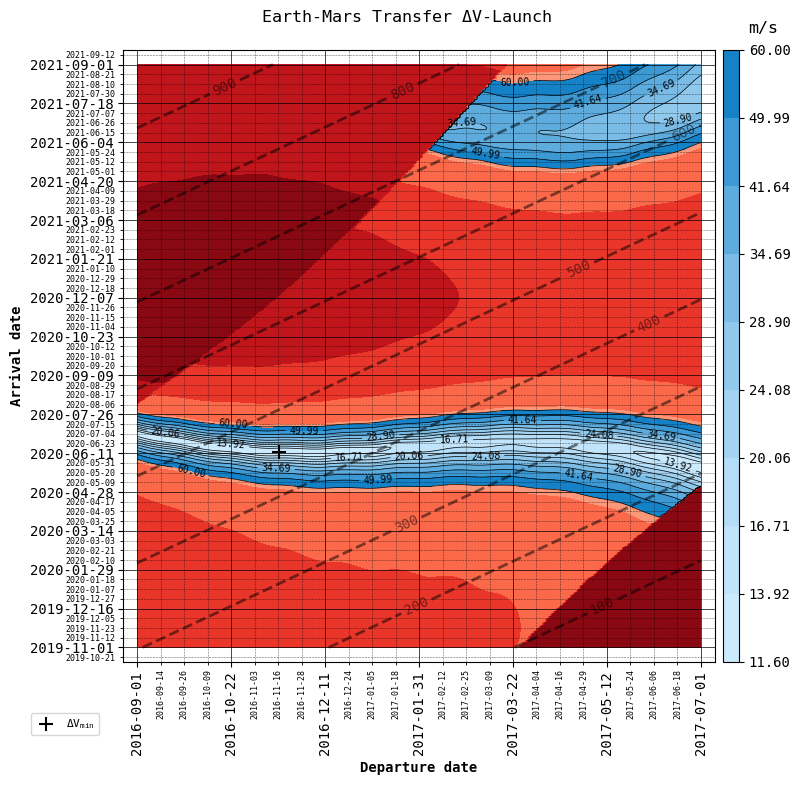

In [12]:

if not os.path.isfile(data_file) or RECALCULATE_delta_v:
    # Regenerate plot
    [departure_epochs, arrival_epochs, ΔV] = porkchop(
        bodies,
        departure_body,
        target_body,
        earliest_departure_time,
        latest_departure_time,
        earliest_arrival_time,
        latest_arrival_time,
        time_resolution,
        function_to_calculate_delta_v=hodographic_low_thrust_trajectory_delta_v
    )
    # Save data
    pickle.dump(
        [departure_epochs, arrival_epochs, ΔV],
        open(data_file, 'wb')
    )
else:
    # Read saved data
    [departure_epochs, arrival_epochs, ΔV] = pickle.load(
        open(data_file, 'rb')
    )
    # Plot saved data
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        threshold        = 60
    )

### Variations

The Tudat `porkchop` module allows us to

- Save the $\Delta V$ map returned by `porkchop` and plot it again without recalculating with the `plot_porkchop` function
- Plot $\Delta V$ (default) or C3 (specific energy), as well as choose whether to plot departure and arrival $\Delta V$ together as the total $\Delta V$ required for the transfer (default), or separately (in those cases in which the manoeuvre is performed in two burns, one at departure and one at arrival to the target planet).

Let's make use of `plot_porkchop` to see all four combinations!

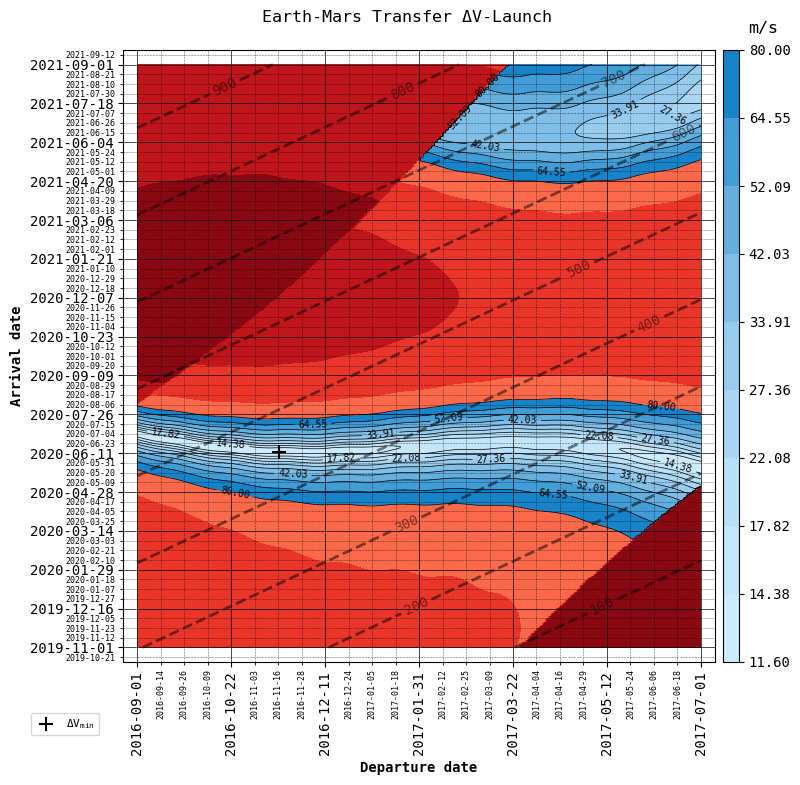

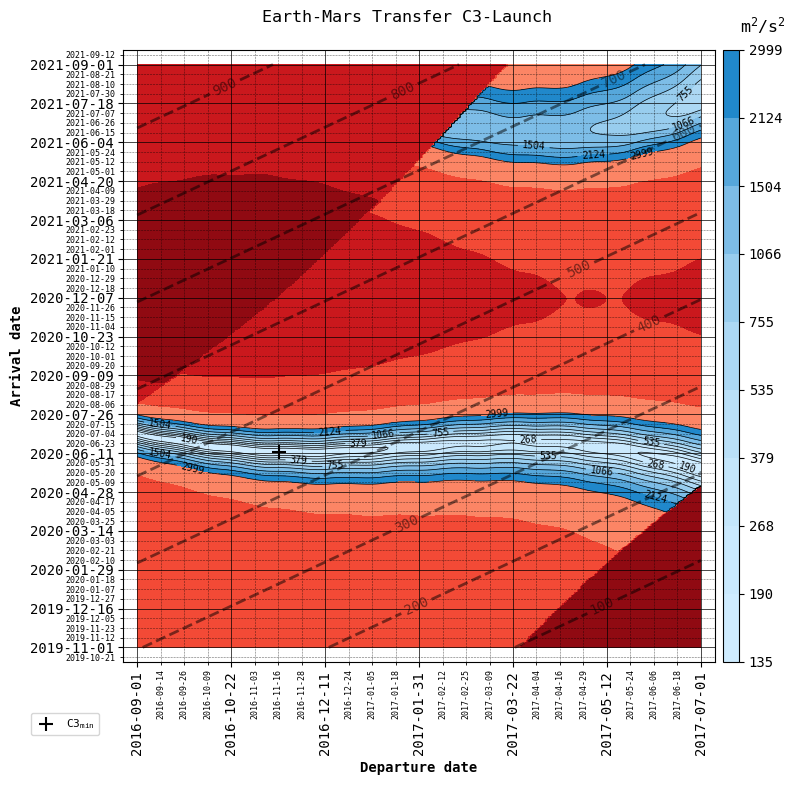

In [14]:
cases = [
    {'C3': False, 'total': True,  'threshold': 80,   'filename': 'figures/Δ_tot.png'},
    {'C3': True,  'total': True,  'threshold': 3000, 'filename': 'figures/C3_tot.png'}
]

for case in cases:
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        save             = False,
        **case
    )
